## A simple binary classifier for stock movements
### Author: Niklas Walter

In this notebook, we present a simple method to predict high-frequency price changes of an undisclosed US stock based on Limit Order Book (LOB) data and past move directions. For simplicity we only consider binary movements, meaning that we do not care about the size of a tick but only its directions. In particular, we label an upward move of the midprice by $1$ and a downward move by $0$, where the midprice is defined as

\begin{equation*}
    \text{midprice} = \frac{\text{bid price} + \text{ask price}}{2}.
\end{equation*}

To make a predicition we use a neural network implemented using `Keras`. As training data `("Dataset_A.csv")` we use the volume and price data from the LOB. In particular, we consider Level 1 and Level 2, where the first one represents the most competitive price respectively and the second the second most competitive order positions. Moreover, we have knowledge about the last five move directions of the stock. The rows of this file have been randomly drawn from a larger data set, and they can be treated as 100,000 iid samples. Hence, no time series structure can be recovered from the data. While we use this first labeled dataset for training and validation purposes, our goal is to make predictions based on the unlabeled data stored in `("Dataset_B_nolabels.csv")`.

Data on high-frequency stock data can for example be found under https://lobsterdata.com .

The notebook is organised as follows. First, we make some simple analyses on the data set to get a first feeling for the data. Secondly, we want to find the optimal architeture for the neural network. Note that the choice is in the end mostly based on the errors of the training and validation epochs. Lastly, we implement the network and run the prediction on the unlabled dataset.


-----

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras

----

### 1. Analysing and manipulating the data 

In the first step, we import the data from a .csv file into a Pandas DataFrame.

In [2]:
data = pd.read_csv("Dataset_A.csv", names = ["Actual Move Direction", "Sell Side Price LV1", "Sell Side Volume LV1", "Buy Side Price LV1", "Buy Side Volume LV1", "Sell Side Price LV2", "Sell Side Volume LV2", "Buy Side Price LV2", "Buy Side Volume LV2", "Past Move 1", "Past Move 2", "Past Move 3", "Past Move 4", "Past Move 5"])

In [3]:
data = data.set_index(np.linspace(1,100000,100000).astype(int))
data.index.name = 'Observations'
data

,Actual Move Direction,Sell Side Price LV1,Sell Side Volume LV1,Buy Side Price LV1,Buy Side Volume LV1,Sell Side Price LV2,Sell Side Volume LV2,Buy Side Price LV2,Buy Side Volume LV2,Past Move 1,Past Move 2,Past Move 3,Past Move 4,Past Move 5
Observations,,,,,,,,,,,,,,
1,0,369900,1043,369800,100,370000,1443,369700,846,1,0,0,0,1
2,0,361800,22721,361600,8875,361900,6835,361500,6068,0,0,0,0,0
3,1,356900,100,356800,1200,357000,500,356700,1056,1,0,1,0,0
4,0,362100,3500,362000,200,362200,7036,361900,3373,0,0,1,1,0
5,0,353600,13946,353400,9739,353700,13885,353300,12701,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,0,363300,19811,363200,100,363400,15558,363100,5015,0,0,0,0,0
99997,0,378100,4110,377900,2345,378200,2045,377800,1645,0,1,0,0,0
99998,1,362800,200,362700,1200,362900,1600,362600,915,0,0,0,0,0


-----

In a first step, we only look at the five past moves and want to see how good the direction of a next move can be predicted using a weighted average of the former moves. The idea behind this is the assumption that the last jump direction contains more information about the next one, than the second last move and so on. 

In [196]:
movements = data.iloc[:,[0,9,10,11,12,13]]
predicitions = pd.DataFrame(np.round(np.average(movements.iloc[:,[1,2,3,4,5]], axis = 1, weights = (1./15, 2./15, 3./15, 4./15, 5./15)).astype(int)), columns = ["Past Moves Prediction"])
predicitions = predicitions.set_index(np.linspace(1,100000,100000).astype(int))
movements = pd.concat([movements, predicitions], axis = 1)
movements = movements.set_index(np.linspace(1,100000,100000).astype(int))
movements

,Actual Move Direction,Past Move 1,Past Move 2,Past Move 3,Past Move 4,Past Move 5,Past Moves Prediction
1,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0
4,0,0,0,1,1,0,0
5,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...
99996,0,0,0,0,0,0,0
99997,0,0,1,0,0,0,0
99998,1,0,0,0,0,0,0
99999,1,1,0,1,0,1,0


A simple computation shows that the accuracy of this method is pretty low. In fact, in the end the prediction is only as good as a coin toss. Therefore, building a network only taking the past moves as input does not look like a promising strategy.

In [202]:
test = np.abs(movements["Actual Move Direction"] - movements["Past Moves Prediction"])
print("Accuracy: " + str(np.round(100*(1.0 - np.sum(test)/len(movements["Actual Move Direction"])),2)) + "%")

Accuracy: 51.68%


Next, we want to use the volumes in the LOB to explain the next move direction. For this we consider both only the volume at Level 1 and the volume at Level 1 and 2 combined. Then the idea is that the volume imbalance defined as 

$$
    I_t := \frac{V^b_t}{V^a_t + V^b_t}
$$

at some time $t$, where $V^a_t$ is the volume at time $t$ on the sell (ask) side and $V^b_t$ on the buy (bid) side. 

In [198]:
total_volume_sell_side = pd.DataFrame(data["Sell Side Volume LV1"] + data["Sell Side Volume LV2"], columns = ["Total Sell Side Volume"])
total_volume_sell_side = total_volume_sell_side.set_index(movements.index)
total_volume_buy_side = pd.DataFrame(data["Buy Side Volume LV1"] + data["Buy Side Volume LV2"], columns = ["Total Buy Side Volume"])
total_volume_buy_side = total_volume_buy_side.set_index(movements.index)
volume_imb_lv1 = pd.DataFrame(data["Buy Side Volume LV1"].to_numpy() / (data["Buy Side Volume LV1"].to_numpy() + data["Sell Side Volume LV1"].to_numpy()), columns = ["Volume Order Imbalance Level 1"])
volume_imb_lv1 = volume_imb_lv1.set_index(movements.index)
total_volume_imb = pd.DataFrame(total_volume_buy_side.to_numpy()/(total_volume_buy_side.to_numpy() + total_volume_sell_side.to_numpy()), columns = ["Volume Order Imbalance Total"])
total_volume_imb = total_volume_imb.set_index(movements.index)
total_volumes = pd.concat([pd.DataFrame(data["Sell Side Volume LV1"]), pd.DataFrame(data["Buy Side Volume LV1"]), total_volume_sell_side, total_volume_buy_side, volume_imb_lv1 , total_volume_imb], axis = 1)
total_volumes

,Sell Side Volume LV1,Buy Side Volume LV1,Total Sell Side Volume,Total Buy Side Volume,Volume Order Imbalance Level 1,Volume Order Imbalance Total
1,1043,100,2486,946,0.087489,0.275641
2,22721,8875,29556,14943,0.280890,0.335805
3,100,1200,600,2256,0.923077,0.789916
4,3500,200,10536,3573,0.054054,0.253243
5,13946,9739,27831,22440,0.411189,0.446381
...,...,...,...,...,...,...
99996,19811,100,35369,5115,0.005022,0.126346
99997,4110,2345,6155,3990,0.363284,0.393297
99998,200,1200,1800,2115,0.857143,0.540230
99999,14604,21577,39537,40774,0.596363,0.507701


Note that in the case $I_t > 0.5 $, there are is more volume on the buy side than on the sell side. Thus from a basic economical idea it is more likely that prices will go up. So we introduce the following prediction $\hat{y}_t$ for the next jump direction

$$
\hat{y}_t = 
\begin{cases} 
    1\; \text{if } I_t > 0.5 \\
    0\; \text{else} 
\end{cases}
$$

In [199]:
predictions2 = pd.DataFrame([1 if imbalance > 0.5 else 0 for imbalance in volume_diff_lv1.to_numpy()], columns=["Volume Order Imbalance Level 1 Prediction"])
predictions2 = predictions2.set_index(movements.index)
predictions3 = pd.DataFrame([1 if imbalance > 0.5 else 0 for imbalance in total_volume_diff.to_numpy()], columns = ["Volume Order Imbalance Total Prediction"])
predictions3 = predictions3.set_index(movements.index)
movements = pd.concat([movements, predictions2, predictions3], axis = 1)
movements

,Actual Move Direction,Past Move 1,Past Move 2,Past Move 3,Past Move 4,Past Move 5,Past Moves Prediction,Volume Order Imbalance Level 1 Prediction,Volume Order Imbalance Total Prediction
1,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,1,1
4,0,0,0,1,1,0,0,0,0
5,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
99996,0,0,0,0,0,0,0,0,0
99997,0,0,1,0,0,0,0,0,0
99998,1,0,0,0,0,0,0,1,1
99999,1,1,0,1,0,1,0,1,1


The next two computations show that for our data sample the direction of the next jump can indeed be pretty good explained by the volume imbalance in the LOB. 

In [204]:
test = np.abs(movements["Actual Move Direction"] - movements["Volume Order Imbalance Level 1 Prediction"])
print("Accuracy: " + str(np.round(100*(1.0 - np.sum(test)/len(movements["Actual Move Direction"])),2)) + "%")

Accuracy: 85.38%


In [205]:
test = np.abs(movements["Actual Move Direction"] - movements["Volume Order Imbalance Total Prediction"])
print("Accuracy: " + str(np.round(100*(1.0 - np.sum(test)/len(movements["Actual Move Direction"])),2)) + "%")

Accuracy: 81.81%


Lastly, we construct a last approach to predict the next move due to the fact that by intuition we do not want our prediction to be only based on two quantities. Therefore, we give it a try to model it by a mix of our volume based approach and a weighted average of the past moves.

In [200]:
mixed_prediction = pd.DataFrame(np.round(2./3 * np.average(movements.iloc[:,[1,2,3,4,5]], axis = 1, weights = (1./15, 2./15, 3./15, 4./15, 5./15)) + 1./3 * movements["Volume Order Imbalance Total Prediction"]).to_numpy().astype(int), columns = ["Mixed Prediction"])
mixed_prediction = mixed_prediction.set_index(np.linspace(1,100000,100000).astype(int))
movements = pd.concat([movements, mixed_prediction], axis = 1)
movements

,Actual Move Direction,Past Move 1,Past Move 2,Past Move 3,Past Move 4,Past Move 5,Past Moves Prediction,Volume Order Imbalance Level 1 Prediction,Volume Order Imbalance Total Prediction,Mixed Prediction
1,0,1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,1,1,1
4,0,0,0,1,1,0,0,0,0,0
5,0,0,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
99996,0,0,0,0,0,0,0,0,0,0
99997,0,0,1,0,0,0,0,0,0,0
99998,1,0,0,0,0,0,0,1,1,0
99999,1,1,0,1,0,1,0,1,1,1


We see that this technique does lead to an improvement to the one only considering the former jump directions. However, it worsens the last two approaches. 

In [207]:
test = np.abs(movements["Actual Move Direction"] - movements["Mixed Prediction"])
print("Accuracy: " + str(np.round(100*(1.0 - np.sum(test) / len(movements["Actual Move Direction"])),2)) + "%")

Accuracy: 70.72%


------

## 2. Define the network architecture

In this section of the notebook, we want to define the optimal network architecture by using high-level analyses. Firstly, our goal is to find the optimal amount of input variables, where we distinguish two cases based on our results from the last section:
1. Take the volumes of the buy and sell side and the information of the past moves.
2. Only take the volumes of the buy and sell side.
Here our main concern is that the first approach could lead to overfitting, which would be indicated by the validation error for the regarding model. 
Secondly, we are interested to find a proper number of neurons for the layers of the network. This means to find a good trade of between accuracy and computation time as well as regrading overfitting again. 

Moreover, we study the difference between using a ReLU and a Leaky-ReLU activation. Recall at this point that the latter overcomes the drawback of the ReLU activation function of setting all negative values to zero which makes differentiating impossible. 

Laslty, note that we normalise the order volume data to make training easier.

In [195]:
avg = np.mean([np.mean(data["Sell Side Volume LV1"]), np.mean(data["Buy Side Volume LV1"]), np.mean(data["Sell Side Volume LV2"]), np.mean(data["Buy Side Volume LV2"])])
print(int(round(avg)))

7169


### Loss Analysis with ReLU activation

To define the network input variables, we need to normalise and reshape them.

In [150]:
N = len(data.index)
input1 = np.reshape([data["Sell Side Volume LV1"].to_numpy()],(N,1)) / avg 
input2 = np.reshape([data["Buy Side Volume LV1"].to_numpy()],(N,1)) / avg 
input3 = np.reshape([data["Sell Side Volume LV2"].to_numpy()],(N,1)) / avg 
input4 = np.reshape([data["Buy Side Volume LV2"].to_numpy()],(N,1)) / avg 
input5 = np.reshape([data["Past Move 1"].to_numpy()],(N,1)) 
input6 = np.reshape([data["Past Move 2"].to_numpy()],(N,1)) 
input7 = np.reshape([data["Past Move 3"].to_numpy()],(N,1)) 
input8 = np.reshape([data["Past Move 4"].to_numpy()],(N,1)) 
input9 = np.reshape([data["Past Move 5"].to_numpy()],(N,1))
X = np.concatenate((input1, input2, input3, input4, input5, input6, input7, input8, input9), axis=1) 
X2 = np.concatenate((input1, input2, input3, input4), axis=1) 
Y = np.reshape([data["Actual Move Direction"].to_numpy()],(N,1))

Using the `Keras` library, define different fully connetced neutral networks of different numbers of neurons. In particular, each model contains of three hiden layers with ReLU as activation and the Sigmoid function as the output function to ensure that the latter lies within $[0,1]$. 
To evaluate the model's performance we split the training set in a only training set and a valuation set. For the training we make use of the Adam optimiser algorithm and take the binary crossentropy as our loss function, which is defined as

$$
\mathcal{l}(x) := - \frac{1}{M}\sum_{i=1}^M y_i \log({\hat{y_i}}) + (1-y_i)\log(\hat{y_i}),
$$

where $M$ is the size of the output, $y_i$ is the $i$-th target value and $\hat{y_i}$ is the $i$-th output value.

Finally, we use a batch size of 200. The relatively small number means within each epoch the model parameters are updated $\approx$ 500 times. This helps the model accuracy convergence by the $7$th epoch.

First, we use the volume data and the information of the past move directions as input variables. 

In [138]:
parameters = [10, 20, 30, 50, 75, 100, 200, 300, 400, 500, 550, 600]
losses = []
val_losses = []
for para in parameters:
    model = keras.Sequential([
        keras.layers.Dense(para, activation="relu", input_shape=(9,)), 
        keras.layers.Dense(para, activation="relu"), 
        keras.layers.Dense(para, activation="relu"), 
        keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) 
    history = model.fit(X, Y, batch_size=200, epochs=10, validation_split=0.5)
    losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])

Epoch 1/10
250/250 [==============================] - 2s 7ms/step - loss: 0.5919 - accuracy: 0.6763 - val_loss: 0.4233 - val_accuracy: 0.8390
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4034 - accuracy: 0.8429 - val_loss: 0.3650 - val_accuracy: 0.8481
Epoch 3/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3605 - accuracy: 0.8488 - val_loss: 0.3511 - val_accuracy: 0.8513
Epoch 4/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3452 - accuracy: 0.8548 - val_loss: 0.3432 - val_accuracy: 0.8535
Epoch 5/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3371 - accuracy: 0.8561 - val_loss: 0.3418 - val_accuracy: 0.8534
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3380 - accuracy: 0.8556 - val_loss: 0.3335 - val_accuracy: 0.8556
Epoch 7/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3288 - accuracy: 0.8595 - val_loss: 0.3298 - val_accuracy: 0.8564
Epoch 

250/250 [==============================] - 1s 4ms/step - loss: 0.2986 - accuracy: 0.8639 - val_loss: 0.3010 - val_accuracy: 0.8641
Epoch 9/10
250/250 [==============================] - 1s 4ms/step - loss: 0.2983 - accuracy: 0.8649 - val_loss: 0.3038 - val_accuracy: 0.8602
Epoch 10/10
250/250 [==============================] - 1s 5ms/step - loss: 0.2935 - accuracy: 0.8647 - val_loss: 0.3008 - val_accuracy: 0.8623
Epoch 1/10
250/250 [==============================] - 2s 6ms/step - loss: 0.4222 - accuracy: 0.8283 - val_loss: 0.3213 - val_accuracy: 0.8574
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3119 - accuracy: 0.8622 - val_loss: 0.3063 - val_accuracy: 0.8633
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3044 - accuracy: 0.8621 - val_loss: 0.3051 - val_accuracy: 0.8622
Epoch 4/10
250/250 [==============================] - 1s 6ms/step - loss: 0.3031 - accuracy: 0.8632 - val_loss: 0.3054 - val_accuracy: 0.8609
Epoch 5/10
250/2

250/250 [==============================] - 5s 21ms/step - loss: 0.2998 - accuracy: 0.8628 - val_loss: 0.3018 - val_accuracy: 0.8619
Epoch 6/10
250/250 [==============================] - 6s 23ms/step - loss: 0.2981 - accuracy: 0.8650 - val_loss: 0.2989 - val_accuracy: 0.8634
Epoch 7/10
250/250 [==============================] - 7s 26ms/step - loss: 0.2966 - accuracy: 0.8634 - val_loss: 0.2991 - val_accuracy: 0.8637
Epoch 8/10
250/250 [==============================] - 7s 27ms/step - loss: 0.2941 - accuracy: 0.8661 - val_loss: 0.3002 - val_accuracy: 0.8641
Epoch 9/10
250/250 [==============================] - 7s 28ms/step - loss: 0.2910 - accuracy: 0.8659 - val_loss: 0.3005 - val_accuracy: 0.8610
Epoch 10/10
250/250 [==============================] - 6s 22ms/step - loss: 0.2912 - accuracy: 0.8673 - val_loss: 0.2993 - val_accuracy: 0.8633


Plotting the loss of the training and valuation of the regarding last epoch, indicates that validation error keeps more or less low even for a higher amount of parameters. This indicates that the problem of overfitting is not that high. Moreover, the loss of the training stablises more or less after $100$ neurons per layer.

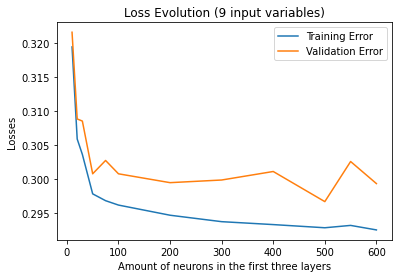

In [159]:
plt.plot(parameters, losses, label = "Training Error")
plt.plot(parameters, val_losses, label = "Validation Error")
plt.legend()
plt.title("Loss Evolution (9 input variables)")
plt.xlabel("Amount of neurons in the first three layers")
plt.ylabel("Losses")
plt.show()

In a next step, we do the same analysis by only taking the volume data as inputs.

In [157]:
parameters = [10, 20, 30, 50, 75, 100, 200, 300, 400, 500, 550, 600]
losses2 = []
val_losses2 = []
for para in parameters:
    model = keras.Sequential([
        keras.layers.Dense(para, activation="relu", input_shape=(4,)), 
        keras.layers.Dense(para, activation="relu"), 
        keras.layers.Dense(para, activation="relu"), 
        keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) 
    history2 = model.fit(X2, Y, batch_size=200, epochs=10, validation_split=0.5)
    losses2.append(history2.history['loss'][-1])
    val_losses2.append(history2.history['val_loss'][-1])

Epoch 1/10
250/250 [==============================] - 1s 3ms/step - loss: 0.5497 - accuracy: 0.7910 - val_loss: 0.4280 - val_accuracy: 0.8459
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4119 - accuracy: 0.8476 - val_loss: 0.3674 - val_accuracy: 0.8508
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3589 - accuracy: 0.8528 - val_loss: 0.3498 - val_accuracy: 0.8506
Epoch 4/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3453 - accuracy: 0.8533 - val_loss: 0.3422 - val_accuracy: 0.8507
Epoch 5/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3430 - accuracy: 0.8484 - val_loss: 0.3421 - val_accuracy: 0.8478
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3360 - accuracy: 0.8521 - val_loss: 0.3364 - val_accuracy: 0.8516
Epoch 7/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3354 - accuracy: 0.8508 - val_loss: 0.3342 - val_accuracy: 0.8509
Epoch 

250/250 [==============================] - 1s 3ms/step - loss: 0.3168 - accuracy: 0.8525 - val_loss: 0.3208 - val_accuracy: 0.8509
Epoch 9/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3165 - accuracy: 0.8529 - val_loss: 0.3206 - val_accuracy: 0.8507
Epoch 10/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3151 - accuracy: 0.8544 - val_loss: 0.3237 - val_accuracy: 0.8498
Epoch 1/10
250/250 [==============================] - 2s 5ms/step - loss: 0.4216 - accuracy: 0.8446 - val_loss: 0.3376 - val_accuracy: 0.8508
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3284 - accuracy: 0.8538 - val_loss: 0.3290 - val_accuracy: 0.8519
Epoch 3/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3238 - accuracy: 0.8526 - val_loss: 0.3238 - val_accuracy: 0.8519
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3218 - accuracy: 0.8539 - val_loss: 0.3273 - val_accuracy: 0.8475
Epoch 5/10
250/2

250/250 [==============================] - 5s 20ms/step - loss: 0.3187 - accuracy: 0.8515 - val_loss: 0.3200 - val_accuracy: 0.8510
Epoch 6/10
250/250 [==============================] - 5s 20ms/step - loss: 0.3181 - accuracy: 0.8535 - val_loss: 0.3194 - val_accuracy: 0.8520
Epoch 7/10
250/250 [==============================] - 5s 20ms/step - loss: 0.3141 - accuracy: 0.8542 - val_loss: 0.3188 - val_accuracy: 0.8514
Epoch 8/10
250/250 [==============================] - 5s 20ms/step - loss: 0.3157 - accuracy: 0.8552 - val_loss: 0.3191 - val_accuracy: 0.8521
Epoch 9/10
250/250 [==============================] - 5s 21ms/step - loss: 0.3140 - accuracy: 0.8539 - val_loss: 0.3189 - val_accuracy: 0.8521
Epoch 10/10
250/250 [==============================] - 5s 21ms/step - loss: 0.3133 - accuracy: 0.8556 - val_loss: 0.3199 - val_accuracy: 0.8511


The error plot indicates that the training loss again stabilizes for $100$ neurons and more. However, the validation error is higher and more fluctant than in the case where we additionally took the past moves as inputs.

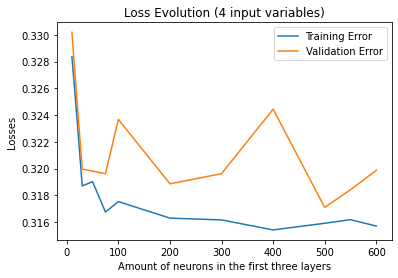

In [158]:
plt.plot(parameters, losses2, label = "Training Error")
plt.plot(parameters, val_losses2, label = "Validation Error")
plt.legend()
plt.title("Loss Evolution (4 input variables)")
plt.xlabel("Amount of neurons in the first three layers")
plt.ylabel("Losses")
plt.show()

------

### Loss Analysis with Leaky ReLU activation

We exactly the same analysis for the Leaky ReLU activation function to see if there are some differences to the "simple" ReLU activation. Note that we choose $\alpha = 0.05$, which defines the slope of the Leaky ReLU function on the negative half-line.

In [208]:
from tensorflow.keras.layers import LeakyReLU
alpha = .05

In [147]:
parameters = [10, 20, 30, 50, 75, 100, 200, 300, 400, 500, 550, 600]
losses3 = []
val_losses3 = []
for para in parameters:
    model = keras.Sequential([
     keras.layers.Dense(para, activation = LeakyReLU(alpha=alpha), input_shape=(9,)),
     keras.layers.Dense(para, activation = LeakyReLU(alpha=alpha)),
     keras.layers.Dense(para, activation = LeakyReLU(alpha=alpha)),
     keras.layers.Dense(1, activation = "sigmoid")]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) 
    history3 = model.fit(X, Y, batch_size=200, epochs=10, validation_split=0.5)
    losses3.append(history3.history['loss'][-1])
    val_losses3.append(history3.history['val_loss'][-1])

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.6830 - accuracy: 0.6030 - val_loss: 0.4249 - val_accuracy: 0.8403
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8451 - val_loss: 0.3726 - val_accuracy: 0.8489
Epoch 3/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3629 - accuracy: 0.8489 - val_loss: 0.3527 - val_accuracy: 0.8523
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3461 - accuracy: 0.8515 - val_loss: 0.3420 - val_accuracy: 0.8550
Epoch 5/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3383 - accuracy: 0.8544 - val_loss: 0.3323 - val_accuracy: 0.8576
Epoch 6/10
250/250 [==============================] - 1s 2ms/step - loss: 0.3290 - accuracy: 0.8573 - val_loss: 0.3287 - val_accuracy: 0.8575
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3280 - accuracy: 0.8581 - val_loss: 0.3231 - val_accuracy: 0.8585
Epoch 

250/250 [==============================] - 1s 3ms/step - loss: 0.2946 - accuracy: 0.8660 - val_loss: 0.3050 - val_accuracy: 0.8619
Epoch 9/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2982 - accuracy: 0.8648 - val_loss: 0.2999 - val_accuracy: 0.8642
Epoch 10/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2962 - accuracy: 0.8657 - val_loss: 0.3024 - val_accuracy: 0.8633
Epoch 1/10
250/250 [==============================] - 2s 5ms/step - loss: 0.4147 - accuracy: 0.8333 - val_loss: 0.3200 - val_accuracy: 0.8608
Epoch 2/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3103 - accuracy: 0.8635 - val_loss: 0.3071 - val_accuracy: 0.8624
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3035 - accuracy: 0.8637 - val_loss: 0.3042 - val_accuracy: 0.8623
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3004 - accuracy: 0.8639 - val_loss: 0.3031 - val_accuracy: 0.8634
Epoch 5/10
250/2

250/250 [==============================] - 6s 22ms/step - loss: 0.2997 - accuracy: 0.8625 - val_loss: 0.3033 - val_accuracy: 0.8605
Epoch 6/10
250/250 [==============================] - 5s 21ms/step - loss: 0.2996 - accuracy: 0.8633 - val_loss: 0.3010 - val_accuracy: 0.8635
Epoch 7/10
250/250 [==============================] - 6s 23ms/step - loss: 0.2965 - accuracy: 0.8633 - val_loss: 0.3009 - val_accuracy: 0.8624
Epoch 8/10
250/250 [==============================] - 5s 22ms/step - loss: 0.2946 - accuracy: 0.8653 - val_loss: 0.2993 - val_accuracy: 0.8635
Epoch 9/10
250/250 [==============================] - 5s 22ms/step - loss: 0.2941 - accuracy: 0.8670 - val_loss: 0.2998 - val_accuracy: 0.8637
Epoch 10/10
250/250 [==============================] - 5s 22ms/step - loss: 0.2964 - accuracy: 0.8636 - val_loss: 0.3036 - val_accuracy: 0.8605


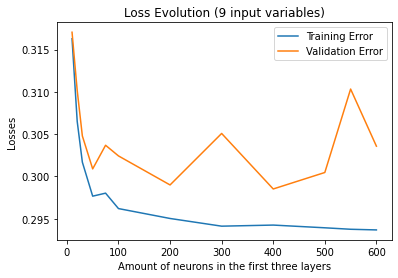

In [155]:
plt.plot(parameters, losses3, label = "Training Error")
plt.plot(parameters, val_losses3, label = "Validation Error")
plt.legend()
plt.title("Loss Evolution (9 input variables)")
plt.xlabel("Amount of neurons in the first three layers")
plt.ylabel("Losses")
plt.show()

In [152]:
parameters = [10, 20, 30, 50, 75, 100, 200, 300, 400, 500, 550, 600]
losses4 = []
val_losses4 = []
for para in parameters:
    model = keras.Sequential([
     keras.layers.Dense(para, activation = LeakyReLU(alpha=alpha), input_shape=(4,)),
     keras.layers.Dense(para, activation = LeakyReLU(alpha=alpha)),
     keras.layers.Dense(para, activation = LeakyReLU(alpha=alpha)),
     keras.layers.Dense(1, activation = "sigmoid")]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) 
    history4 = model.fit(X2, Y, batch_size=200, epochs=10, validation_split=0.5)
    losses4.append(history4.history['loss'][-1])
    val_losses4.append(history4.history['val_loss'][-1])

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.5910 - accuracy: 0.7259 - val_loss: 0.4447 - val_accuracy: 0.8427
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.4391 - accuracy: 0.8436 - val_loss: 0.4065 - val_accuracy: 0.8497
Epoch 3/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.8525 - val_loss: 0.3732 - val_accuracy: 0.8470
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3665 - accuracy: 0.8499 - val_loss: 0.3535 - val_accuracy: 0.8492
Epoch 5/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3474 - accuracy: 0.8529 - val_loss: 0.3456 - val_accuracy: 0.8504
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3430 - accuracy: 0.8520 - val_loss: 0.3433 - val_accuracy: 0.8500
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.3337 - accuracy: 0.8548 - val_loss: 0.3383 - val_accuracy: 0.8509
Epoch 

250/250 [==============================] - 1s 3ms/step - loss: 0.3222 - accuracy: 0.8516 - val_loss: 0.3191 - val_accuracy: 0.8525
Epoch 9/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3173 - accuracy: 0.8531 - val_loss: 0.3199 - val_accuracy: 0.8508
Epoch 10/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3184 - accuracy: 0.8524 - val_loss: 0.3189 - val_accuracy: 0.8516
Epoch 1/10
250/250 [==============================] - 2s 5ms/step - loss: 0.4152 - accuracy: 0.8416 - val_loss: 0.3415 - val_accuracy: 0.8479
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3344 - accuracy: 0.8515 - val_loss: 0.3256 - val_accuracy: 0.8493
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3250 - accuracy: 0.8507 - val_loss: 0.3222 - val_accuracy: 0.8519
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3199 - accuracy: 0.8524 - val_loss: 0.3211 - val_accuracy: 0.8518
Epoch 5/10
250/2

250/250 [==============================] - 6s 26ms/step - loss: 0.3187 - accuracy: 0.8520 - val_loss: 0.3221 - val_accuracy: 0.8513
Epoch 6/10
250/250 [==============================] - 6s 23ms/step - loss: 0.3191 - accuracy: 0.8547 - val_loss: 0.3215 - val_accuracy: 0.8505
Epoch 7/10
250/250 [==============================] - 6s 24ms/step - loss: 0.3209 - accuracy: 0.8501 - val_loss: 0.3320 - val_accuracy: 0.8481
Epoch 8/10
250/250 [==============================] - 6s 23ms/step - loss: 0.3157 - accuracy: 0.8529 - val_loss: 0.3203 - val_accuracy: 0.8517
Epoch 9/10
250/250 [==============================] - 5s 20ms/step - loss: 0.3169 - accuracy: 0.8529 - val_loss: 0.3200 - val_accuracy: 0.8513
Epoch 10/10
250/250 [==============================] - 6s 23ms/step - loss: 0.3127 - accuracy: 0.8551 - val_loss: 0.3192 - val_accuracy: 0.8507


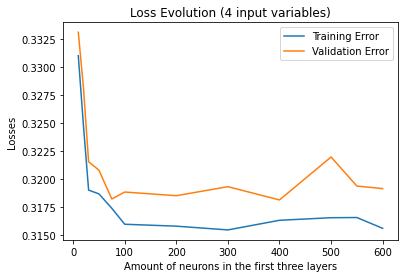

In [154]:
plt.plot(parameters, losses4, label = "Training Error")
plt.plot(parameters, val_losses4, label = "Validation Error")
plt.legend()
plt.title("Loss Evolution (4 input variables)")
plt.xlabel("Amount of neurons in the first three layers")
plt.ylabel("Losses")
plt.show()

-----

### 3. Implenting the final model and run the prediction of the move directions.

Since the Leaky ReLU does not come along with big improvements regrading the losses, we use the ReLU function for the activation of our final model. Moreover, we choose the number of neurons to $100$ due to the fact that the plots indicate not a much lower loss for a higher number and so we can benefit from a lower computation time. Lastly, we take the volume data and the information of the past moves as our inputs since this does not lead to any overfitting as displayed by the validation loss.

### Setup of final model 

In [162]:
modelfinal = keras.Sequential([
     keras.layers.Dense(100, activation = 'relu', input_shape=(9,)),
     keras.layers.Dense(100, activation = 'relu'),
     keras.layers.Dense(100, activation = 'relu'),
     keras.layers.Dense(1, activation = "sigmoid")]
    )
modelfinal.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) 
modelfinal.fit(X, Y, batch_size=200, epochs=10, validation_split=0.5)

Epoch 1/10
250/250 [==============================] - 2s 5ms/step - loss: 0.4439 - accuracy: 0.8110 - val_loss: 0.3257 - val_accuracy: 0.8570
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3197 - accuracy: 0.8592 - val_loss: 0.3081 - val_accuracy: 0.8633
Epoch 3/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3034 - accuracy: 0.8658 - val_loss: 0.3103 - val_accuracy: 0.8588
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3020 - accuracy: 0.8648 - val_loss: 0.3074 - val_accuracy: 0.8607
Epoch 5/10
250/250 [==============================] - 1s 6ms/step - loss: 0.3034 - accuracy: 0.8618 - val_loss: 0.3013 - val_accuracy: 0.8638
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2938 - accuracy: 0.8676 - val_loss: 0.3004 - val_accuracy: 0.8645
Epoch 7/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3009 - accuracy: 0.8622 - val_loss: 0.3036 - val_accuracy: 0.8613
Epoch 

### Stock tick prediction

First, we save the unlabelled dataset in a Pandas DataFrame. 

In [23]:
data2 = pd.read_csv("Dataset_B_nolabels.csv", names = data.columns[1:]) 
data2.head()

,Sell Side Price LV1,Sell Side Volume LV1,Buy Side Price LV1,Buy Side Volume LV1,Sell Side Price LV2,Sell Side Volume LV2,Buy Side Price LV2,Buy Side Volume LV2,Past Move 1,Past Move 2,Past Move 3,Past Move 4,Past Move 5
0,356300,2200,356100,1745,356400,1845,356000,1745,0,0,0,1,0
1,354400,13398,354300,1,354500,13605,354200,10766,0,0,0,0,1
2,359600,6702,359400,24404,359700,4801,359300,9986,1,0,1,0,1
3,358600,4857,358500,300,358700,3498,358400,3577,1,1,0,0,0
4,365600,3500,365400,3047,365700,3301,365300,2045,0,0,0,0,0


After reshaping the input variables properly, we use the model implemented above to predict the next move direction. Note that we use the `np.round()` method to end up with either $0$ or $1$.

In [209]:
N2 = len(data2.index)
avg = np.mean([np.mean(data2["Sell Side Volume LV1"]), np.mean(data2["Buy Side Volume LV1"]), np.mean(data2["Sell Side Volume LV2"]), np.mean(data2["Buy Side Volume LV2"])])
a1 = np.reshape([data2["Sell Side Volume LV1"].to_numpy()], (N2,1)) / avg 
a2 = np.reshape([data2["Buy Side Volume LV1"].to_numpy()], (N2,1)) / avg 
a3 = np.reshape([data2["Sell Side Volume LV2"].to_numpy()], (N2,1)) / avg 
a4 = np.reshape([data2["Buy Side Volume LV2"].to_numpy()], (N2,1)) / avg 
a5 = np.reshape([data2["Past Move 1"].to_numpy()], (N2,1)) 
a6 = np.reshape([data2["Past Move 2"].to_numpy()], (N2,1)) 
a7 = np.reshape([data2["Past Move 3"].to_numpy()], (N2,1)) 
a8 = np.reshape([data2["Past Move 4"].to_numpy()], (N2,1)) 
a9 = np.reshape([data2["Past Move 5"].to_numpy()], (N2,1))
X = np.concatenate((a1, a2, a3, a4, a5, a6, a7, a8, a9), axis = 1) 
final_prediction = np.reshape(np.round(modelfinal.predict(X)).astype(int), (N2,))

In [210]:
final_prediction

array([0, 0, 1, ..., 0, 0, 1])